In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src/transformers')
import os
device_mappings = {0: 1, 1: 5, 2: 6, 3: 7, 4: 2, 5: 3, 6: 0, 7: 4}
os.environ["CUDA_VISIBLE_DEVICES"] = str(device_mappings[7])

import random
import string
from collections import defaultdict, OrderedDict
from itertools import product, chain
import numpy as np
from pattern.en import comparative

import matplotlib.pyplot as plt
import seaborn as sns

from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [116]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from enum import Enum
from typing import List, Optional, Union

from child_frames import frames
from utils import *

import logging
import os
import sys

from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed
from transformers import PreTrainedModel, RobertaForMaskedLM, RobertaTokenizer
from transformers.modeling_roberta import RobertaForProbing, RobertaDoubleHeadsModel, \
    RobertaDoubleHeadsModel2, RobertaDoubleHeadsModel3  # XD
from transformers.trainer import get_mean_pred_prob  # XD

logging.basicConfig(level=logging.ERROR)

In [4]:
A_template = "{rel_prefix} {dt} {ent0} {rel} {dt} {ent1} {rel_suffix}"
B_template = "{pred_prefix} {dt} {ent} {pred}"
entailment_templates = ["{A} ? {conj} , {B} .", "{A} , so {B} ? {conj} ."]

markers = {'lexical': '*', 'entity': '#'}

def extract_rel_id(s): return int(s[s.index(':') + 1])
def extract_rel(s): return [t.split(':')[0] for t in s.split() if ':' in t][0]
def strip_rel_id(s, lexical_rel=''):
    rel_id_span = s[s.index(':'): s.index(':') + 2]
    if lexical_rel != '': lexical_rel = ' ( ' + lexical_rel + ' )'
    return s.replace(rel_id_span, lexical_rel)
        
relation_labels = {'entity': ['former', 'latter'], 'lexical': ['same', 'opposite', 'unrelated']}

def make_sentences(entities=['_X', '_Z'], entity_set=string.ascii_uppercase, determiner="",
                   relation_group=[["confident",], ["uncertain",]], rand_relation_group=[["short"], ["tall", "high"]],
                   relation_prefix="", relation_suffix="", predicate_prefix="",
                   n_entity_trials=3, has_negA=True, has_negB=True, has_neutral=False, mask_types={'sent_rel'}, 
                   lexical_relations=None, entity_relations=None, tag_lexical_rel=False, tag_entity_rel=False):
#     if tag_lexical_rel: mask_types.add('lexical_rel')
#     if tag_entity_rel: mask_types.add('entity_rel')
    def get_comparative(word):
        compar = comparative(word)
        if tag_lexical_rel:
            marker = markers['lexical']
            compar = compar.replace('more ', 'more %s ' % marker) if compar.startswith('more ') else marker + ' ' + compar
        return compar
  
    def form_As(relations):
        return [A_template.format(dt=determiner, ent0=ent0, ent1=ent1, rel=rel, 
                                  rel_prefix=relation_prefix, rel_suffix=relation_suffix)
              for ent0, ent1, rel in [entities + relations[:1], reverse(entities) + reverse(relations)[:1]]]
    As = []
    for rel0 in relation_group[0]:
        for rel1 in relation_group[1]:
            relations = ["is %s:%d than" % (get_comparative(rel), i) for i, rel in enumerate([rel0, rel1])]
            As += form_As(relations)
    As = list(set(As))
    negAs = join_lists([negate_sent(A)[:1] for A in As]) if has_negA else []

    def form_Bs(predicates): 
        f = mask if 'entity' in mask_types else (lambda x: x)
        return [B_template.format(dt=determiner, ent=f(ent), pred=pred, pred_prefix=predicate_prefix)
              for ent, pred in zip(entities, predicates)]

    Bs, negBs = {'orig': [], 'rand': []}, {}
    for k, group in zip(['orig', 'rand'], [relation_group, rand_relation_group]):
        for rel0 in group[0]:
            for rel1 in group[1]:
                predicates = ["is %s:%d" % (get_comparative(rel), i) for i, rel in enumerate([rel0, rel1])]
                Bs[k] += form_Bs(predicates)
    for k in Bs:
        Bs[k] = list(set(Bs[k]))
        if has_negB:
            negBs[k] = join_lists([negate_sent(B)[:1] for B in Bs[k]])
            Bs[k], negBs[k] = Bs[k] + [swap_entities(negB) for negB in negBs[k]], negBs[k] + [swap_entities(B) for B in Bs[k]]
        else:
            negBs[k] = [swap_entities(B) for B in Bs[k]]
      
    comparatives = [comparative(r).replace('more ', '') for r in join_lists(relation_group) + join_lists(rand_relation_group)]
    def form_sentences(sentence_template, As, Bs, conj):
        def compare_and_tag_comparative(A, B):
            if 'Maybe' in conj:
                lexical_rel = 'unrelated'
            else:
                lexical_rel = 'same' if extract_rel_id(A) == extract_rel_id(B) else 'opposite'
            if lexical_relations and lexical_rel not in lexical_relations:
                return None, None
            if 'lexical_rel' in mask_types: lexical_rel = mask(lexical_rel)
            return strip_rel_id(A), strip_rel_id(B, lexical_rel)
#             triple = '%s %s %s' % (extract_rel(A), lexical_rel, extract_rel(B))
#             return strip_rel_id(A), strip_rel_id(B), triple
        def tag_entity(token, recurred_entity, entity_rel=None):
            if token != recurred_entity: return token
            return markers['entity'] + ' ' + token
#             if token not in entities: return token
#             entity_rel = 'paired' if token == recurred_entity else 'single'
#             if 'entity_rel' in mask_types: entity_rel = mask(entity_rel)
#             return token + ' ( %s )' % entity_rel
        def compare_and_tag_entity(A, B):
            recurred_entity = [e for e in entities if e in B.split()][0]
            A = ' '.join([tag_entity(token, recurred_entity) for token in A.split()])
            B = ' '.join([tag_entity(token, recurred_entity) for token in B.split()])
            entity_rel = 'former' if A.split().index(recurred_entity) in [0, 1] else 'latter'
            if entity_relations and entity_rel not in entity_relations: return None, None
            if 'entity_rel' in mask_types: entity_rel = mask(entity_rel)
            return A, B.replace(recurred_entity, recurred_entity + ' ( ' + entity_rel + ' )')
#             triple = '%s %s %s' % (recurred_entity, entity_rel, recurred_entity)
#             return A, B, triple
        
        if 'sent_rel' in mask_types: conj = mask(conj)
        sentences = []
        cores = []
        for A, B in product(As, Bs):
            A, B = compare_and_tag_comparative(A, B) \
                if tag_lexical_rel else (strip_rel_id(A), strip_rel_id(B))
            if A is None: continue
#             entity_triple = None
            if tag_entity_rel: A, B = compare_and_tag_entity(A, B)
            if A is None: continue
            sent = sentence_template.format(A=A, B=B, conj=conj)
#             triples = ' , '.join([t for t in [entity_triple, lexical_triple] if t is not None])
#             if triples: sent = sent + ' Hint : ' + triples
            sent = " " + " ".join(sent.split())
            if True: #for sent_type in sentence_types:
                sentences.append(sent)
                for rel_type in {'entity', 'lexical'}:
                    if not locals()['tag_' + rel_type + '_rel']: continue
#                 if 'core' in sent_type:
#                     rel_type = sent_type.split('_')[1]
#                     assert rel_type in {'entity', 'lexical'}
                    the_other_rel_type = ({'entity', 'lexical'} - {rel_type}).pop()
                    excluded_tokens = comparatives if rel_type == 'entity' else entities
                    # wrong, because it will change the default value of entities!
                    # excluded_tokens += ['is', 'not', 'less', 'more', 'than', 'so'] + list(markers.values()) 
                    excluded_tokens = excluded_tokens + ['is', 'not', 'less', 'more', 'than', 'so'] + list(markers.values())
                    core = sent.split('?')[0]
                    for span in ['( [ %s ] )' % r for r in relation_labels[the_other_rel_type]]:
                        core = core.replace(span, '')
                    core = [token for token in core.split() if token not in excluded_tokens]
                    core = " " + " ".join(core)
                    core = core.replace('(', '?').replace(')', '.')
                    cores.append(core)
        return sentences, cores
    
    sentences = defaultdict(list)
    cores = defaultdict(list)
    for entailment_template in entailment_templates[-1:]:
        for A, B, conj in [(As, Bs['orig'], 'Right'), (negAs, negBs['orig'], 'Right'), 
                           (As, negBs['orig'], 'Wrong'), (negAs, Bs['orig'], 'Wrong'),
                           (As, Bs['rand'], 'Maybe'), (negAs, negBs['rand'], 'Maybe'), 
                           (As, negBs['rand'], 'Maybe'), (negAs, Bs['rand'], 'Maybe')]:
            ss, cs = form_sentences(entailment_template, A, B, conj)
            sentences[conj] += ss
            cores[conj] += cs
    assert len(sentences['Right']) == len(sentences['Wrong']), \
        '%d %d' % (len(sentences['Right']), len(sentences['Wrong']))
    if has_neutral:
        sentences['Maybe'] = random.sample(sentences['Maybe'], len(sentences['Right']))
    keys = sentences.keys() if has_neutral else ['Right', 'Wrong']
    sentences = join_lists(sentences[k] for k in keys)
    
    def substitute(templates, n_entity_trials):
        substituted_groups = []
        for template in templates:
            group = []
            for _ in range(n_entity_trials):
                e0, e1 = random.sample(entity_set, 2)
                group.append(template.replace(entities[0], e0).replace(entities[1], e1))
            substituted_groups.append(group)
        return substituted_groups
    
    substituted_sent_groups = substitute(sentences, n_entity_trials=n_entity_trials)
    cores = list(set(join_lists(cores[k] for k in keys)))
    cores = balance(cores, relation_labels)
    substituted_core_groups = substitute(cores, n_entity_trials=1)
    return sentences, cores, substituted_sent_groups, substituted_core_groups

make_sentences(has_negA=False, has_negB=False, has_neutral=False, tag_lexical_rel=True, tag_entity_rel=False,
               mask_types={'sent_rel'})[:2] # ,

([' _Z is more * uncertain than _X , so _Z is more * uncertain ( same ) ? [ Right ] .',
  ' _Z is more * uncertain than _X , so _X is more * confident ( opposite ) ? [ Right ] .',
  ' _X is more * confident than _Z , so _Z is more * uncertain ( opposite ) ? [ Right ] .',
  ' _X is more * confident than _Z , so _X is more * confident ( same ) ? [ Right ] .',
  ' _Z is more * uncertain than _X , so _X is more * uncertain ( same ) ? [ Wrong ] .',
  ' _Z is more * uncertain than _X , so _Z is more * confident ( opposite ) ? [ Wrong ] .',
  ' _X is more * confident than _Z , so _X is more * uncertain ( opposite ) ? [ Wrong ] .',
  ' _X is more * confident than _Z , so _Z is more * confident ( same ) ? [ Wrong ] .'],
 [' confident , uncertain ? opposite .',
  ' uncertain , confident ? opposite .',
  ' confident , confident ? same .',
  ' uncertain , uncertain ? same .'])

In [5]:
def make_transitive(entities=["_X", "_Y", "_Z"], entity_set=string.ascii_uppercase,
                    relation_group=[["confident", ], ["uncertain", ]], n_entity_trials=3,
                    has_negP=True, has_negQ=True, has_neutral=False, mask_types=['sent_rel']):
    def form_atoms(relations, entities, has_neg=True):
        atoms = [P_template.format(ent0=ent0, ent1=ent1, rel=rel) for ent0, ent1, rel in
                 [entities + relations[:1], reverse(entities) + reverse(relations)[:1]]]
        if has_neg:
            neg_rels = [negate_sent(r)[0] for r in relations]
            atoms += [P_template.format(ent0=ent0, ent1=ent1, rel=rel) for ent0, ent1, rel in
                      [entities + reverse(neg_rels)[:1], reverse(entities) + neg_rels[:1]]]
        return atoms

    def form_sentences(transitive_template, Ps, Qs, conj):
        sentences = []
        if 'sent_rel' in mask_types: conj = mask(conj)
        for (p0, p1), Q in product(Ps, Qs):
            sent = transitive_template.format(p0=strip_rel_id(p0), p1=strip_rel_id(p1),
                                              Q=strip_rel_id(Q), conj=conj)
            sent = " " + " ".join(sent.split())
            sentences.append(sent)
        return sentences

    def form_all(P0_entities, P1_entities, Q_entities, neutral=False):
        P0, P1 = [], []
        for rel0 in relation_group[0]:
            for rel1 in relation_group[1]:
                relations = [" is %s:%d than" % (comparative(rel), i)
                             for i, rel in enumerate([rel0, rel1])]
                P0 += form_atoms(relations, P0_entities, has_neg=has_negP)
                P1 += form_atoms(relations, P1_entities, has_neg=has_negP)
        Ps = [(p0, p1) for p0, p1 in list(product(P0, P1)) + list(product(P1, P0))]

        Qs = form_atoms(relations, Q_entities, has_neg=has_negQ)
        negQs = [swap_entities(Q, *Q_entities) for Q in Qs]

        for P, Q, conj in [(Ps, Qs, 'Right'), (Ps, negQs, 'Wrong')]:
            if neutral: conj = 'Maybe'
            sentences[conj] += form_sentences(transitive_template, P, Q, conj)
        return sentences

    e0, e1, e2 = entities
    sentences = defaultdict(list)
    form_all(P0_entities=[e0, e1], P1_entities=[e1, e2], Q_entities=[e0, e2])
    assert len(sentences['Right']) == len(sentences['Wrong']), \
        '%d %d' % (len(sentences['Right']), len(sentences['Wrong']))
    sample_ratio = len(relation_group[0]) * len(relation_group[1])
    if sample_ratio > 1:
        for key in sentences:
            sentences[key] = random.sample(sentences[key], len(sentences[key]) // sample_ratio)
#     print('nRight =', len(sentences['Right']))
    if has_neutral:
        form_all(P0_entities=[e0, e1], P1_entities=[e0, e2], Q_entities=[e1, e2], neutral=True)
        sentences['Maybe'] = random.sample(sentences['Maybe'], len(sentences['Right']))
    keys = sentences.keys() if has_neutral else ['Right', 'Wrong']
    sentences = join_lists(sentences[k] for k in keys)

    substituted_sent_groups = []
    for sent in sentences:
        sent_group = []
        for _ in range(n_entity_trials):
            e0, e1, e2 = random.sample(entity_set, 3)
            sent_group.append(sent.replace(entities[0], e0)
                              .replace(entities[1], e1)
                              .replace(entities[2], e2))
        substituted_sent_groups.append(sent_group)
    return sentences, substituted_sent_groups

# make_transitive(has_negP=True, has_negQ=True, has_neutral=True, mask_types=['sent_rel'])[1]

In [6]:
tokenizer_class, shortcut = RobertaTokenizer, 'roberta-base'
tokenizer = tokenizer_class.from_pretrained(shortcut)

In [7]:
## rand_relation_group=_frames[(i + 1) % len(_frames)], 
random.seed(42)
random.shuffle(frames)
entity_set = list(string.ascii_uppercase)
random.shuffle(entity_set)
split_pct = [0.7, 0.3]

In [8]:
tag2id = {'same': 0, 'opposite': 1, 'unrelated': 2, 'former': 0, 'latter': 1, 'another': 5, 'single': 6, 'paired': 7}
tag2id = {'Ġ' + k: v for k, v in tag2id.items()}
id2tag = {v: k for k, v in tag2id.items()}

n_entity_trials = 3
kwargs = {'n_entity_trials': n_entity_trials, 'has_neutral': False, 'has_negA': False, 'has_negB': False, 
          'tag_lexical_rel': False, 'tag_entity_rel': True, 'mask_types': {'sent_rel',}}
train_lines, eval_lines = [[make_sentences(relation_group=rg, entity_set=_ent_set, **kwargs)[2] for i, rg in enumerate(_frames)]
                           for _frames, _ent_set in zip(split(frames, split_pct), split(entity_set, split_pct))]
random.sample(flatten(train_lines), 10)
# all_lines = [make_transitive(relation_group=rg, n_entity_trials=n_entity_trials,
#                              has_negP=True, has_negQ=True, has_neutral=True, mask_types=['sent_rel'])[1]
#              for i, rg in enumerate(frames)]
# all_lines = join_lists(all_lines)
# all_lines = join_lists(all_lines)
tokenizer.tag2id, tokenizer.id2tag = tag2id, id2tag
# for k in CHILDDataset.all_lines: CHILDDataset.all_lines[k] = None
kwargs = {'has_tags': True, 'max_noise_len': 0, 'n_replicas': 1}
train_dataset = CHILDDataset(train_lines, tokenizer, mode='train', **kwargs)
eval_dataset = CHILDDataset(eval_lines, tokenizer, mode='dev', **kwargs)
print('nTrain = %d, nValid = %d' % (len(train_dataset), len(eval_dataset)))

[' A is more unlawful than # F , so # F ( latter ) is more lawful ? [ Right ] .',
 ' L is more hesitant than # X , so # X ( latter ) is more hesitant ? [ Wrong ] .',
 ' # J is smaller than E , so # J ( former ) is bigger ? [ Wrong ] .',
 ' # Q is more dishonest than H , so # Q ( former ) is more honest ? [ Wrong ] .',
 ' R is more endemic than # Y , so # Y ( latter ) is more endemic ? [ Wrong ] .',
 ' F is brighter than # E , so # E ( latter ) is darker ? [ Right ] .',
 ' # X is more unnatural than Q , so # X ( former ) is more natural ? [ Wrong ] .',
 ' # D is fewer than Y , so # D ( former ) is less ? [ Right ] .',
 ' I is more arrogant than # Y , so # Y ( latter ) is more modest ? [ Right ] .',
 ' N is more unwilling than # B , so # B ( latter ) is more unwilling ? [ Wrong ] .']

nTrain = 2562, nValid = 1122


In [112]:
# model_class, model = RobertaForMaskedLM, None
model_class, model = RobertaForProbing, None
model = model_class.from_pretrained('roberta-base', state_dict=state_dict)
steps = max(int(round(100 * n_entity_trials / 3)), int(len(train_dataset) / 32 / 4))
training_args = TrainingArguments(output_dir="./models/model_name", 
    overwrite_output_dir=True, do_train=True, do_eval=True,
    per_device_train_batch_size=32, per_device_eval_batch_size=64,
    learning_rate=2e-4, num_train_epochs=10,
    logging_steps=steps, eval_steps=steps, save_steps=0,
    no_cuda=False, evaluate_during_training=True,
)
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset)
trainer.tokenizer = tokenizer
model.tokenizer = tokenizer
trainer.train()

{'loss': 0.672442, 'learning_rate': 0.00017530864197530866, 'epoch': 1.235, 'step': 100}



0  0.50/0.51  0.62/0.51  0.76/0.50  0.50/0.51  0.62/0.50  0.51/0.50  0.78/0.50  0.55/0.51  0.50/0.50  0.78/0.52  0.87/0.56  0.73/0.51  
1  0.79/0.55  0.50/0.51  0.81/0.55  0.82/0.55  0.50/0.50  0.79/0.54  0.50/0.51  0.76/0.54  0.66/0.50  0.77/0.60  0.65/0.51  0.73/0.53  
2  0.79/0.52  0.99/0.54  0.87/0.56  0.90/0.53  0.76/0.55  0.91/0.56  0.90/0.57  0.85/0.56  0.78/0.52  0.84/0.54  0.61/0.53  0.86/0.57  



{'loss': 0.642218, 'learning_rate': 0.0001506172839506173, 'epoch': 2.469, 'step': 200}



0  0.55/0.51  0.74/0.52  0.77/0.50  0.50/0.51  0.51/0.50  0.63/0.50  0.79/0.51  0.67/0.51  0.55/0.50  0.91/0.53  0.88/0.60  0.93/0.51  
1  0.80/0.57  0.53/0.51  0.84/0.58  0.85/0.57  0.51/0.50  0.76/0.58  0.50/0.51  0.74/0.57  0.51/0.50  0.80/0.66  0.80/0.52  0.74/0.55  
2  0.79/0.53  0.98/0.58  0.92/0.61  0.94/0.54  0.79/0.58  0.93/0.59  0.92/0.62  0.86/0.60  0.77/0.53  0.83/0.57  0.85/0.55  0.86/0.61  



{'loss': 0.623007, 'learning_rate': 0.00012592592592592592, 'epoch': 3.704, 'step': 300}



0  0.66/0.51  0.81/0.52  0.98/0.50  0.50/0.51  0.66/0.50  0.99/0.51  0.78/0.51  0.84/0.51  0.72/0.50  0.90/0.54  0.90/0.63  0.90/0.52  
1  0.80/0.59  0.83/0.52  0.89/0.61  0.86/0.60  0.50/0.50  0.75/0.61  0.51/0.50  0.74/0.59  0.91/0.50  0.82/0.69  0.81/0.52  0.74/0.57  
2  0.78/0.54  0.95/0.60  0.91/0.65  0.94/0.56  0.81/0.60  0.93/0.62  0.93/0.65  0.88/0.63  0.76/0.54  0.82/0.60  0.88/0.57  0.86/0.65  



{'loss': 0.608555, 'learning_rate': 0.00010123456790123458, 'epoch': 4.938, 'step': 400}



0  0.68/0.51  0.83/0.52  0.97/0.50  0.50/0.51  0.57/0.50  1.00/0.51  0.77/0.51  0.87/0.51  0.91/0.50  0.94/0.54  0.90/0.65  0.91/0.52  
1  0.80/0.61  0.88/0.53  0.93/0.64  0.86/0.61  0.50/0.50  0.75/0.63  0.53/0.50  0.74/0.61  0.90/0.50  0.83/0.71  0.82/0.53  0.73/0.59  
2  0.77/0.55  0.93/0.62  0.92/0.68  0.94/0.57  0.83/0.61  0.94/0.64  0.94/0.67  0.89/0.66  0.76/0.55  0.83/0.62  0.88/0.59  0.86/0.67  



{'loss': 0.600835, 'learning_rate': 7.65432098765432e-05, 'epoch': 6.173, 'step': 500}



0  0.71/0.51  0.84/0.53  0.95/0.51  0.50/0.51  0.69/0.50  1.00/0.51  0.77/0.51  0.91/0.51  0.93/0.50  0.94/0.55  0.90/0.66  0.90/0.53  
1  0.81/0.63  0.88/0.54  0.95/0.65  0.86/0.62  0.50/0.50  0.75/0.65  0.54/0.50  0.74/0.63  0.85/0.50  0.84/0.73  0.82/0.53  0.74/0.60  
2  0.78/0.55  0.93/0.64  0.92/0.69  0.93/0.58  0.85/0.62  0.94/0.65  0.94/0.69  0.89/0.67  0.76/0.56  0.82/0.64  0.88/0.61  0.86/0.68  



{'loss': 0.592923, 'learning_rate': 5.185185185185185e-05, 'epoch': 7.407, 'step': 600}



0  0.74/0.51  0.85/0.53  0.96/0.51  0.52/0.51  0.69/0.50  1.00/0.51  0.78/0.51  0.93/0.51  0.92/0.50  0.94/0.55  0.91/0.67  0.90/0.53  
1  0.81/0.64  0.88/0.54  0.96/0.67  0.87/0.64  0.50/0.50  0.75/0.65  0.54/0.50  0.73/0.64  0.65/0.50  0.84/0.73  0.82/0.53  0.73/0.61  
2  0.79/0.56  0.92/0.65  0.92/0.70  0.92/0.59  0.86/0.64  0.95/0.66  0.94/0.70  0.90/0.68  0.76/0.56  0.82/0.65  0.87/0.61  0.85/0.69  



{'loss': 0.583881, 'learning_rate': 2.7160493827160493e-05, 'epoch': 8.642, 'step': 700}



0  0.73/0.51  0.84/0.53  0.96/0.51  0.52/0.51  0.70/0.50  1.00/0.51  0.77/0.51  0.92/0.51  0.91/0.50  0.94/0.55  0.91/0.68  0.91/0.53  
1  0.81/0.65  0.88/0.54  0.96/0.67  0.87/0.64  0.65/0.50  0.75/0.66  0.51/0.50  0.73/0.65  0.71/0.50  0.85/0.74  0.82/0.53  0.73/0.61  
2  0.79/0.56  0.93/0.65  0.93/0.70  0.92/0.59  0.87/0.64  0.95/0.67  0.94/0.70  0.90/0.69  0.76/0.56  0.82/0.65  0.88/0.62  0.85/0.69  



{'loss': 0.585851, 'learning_rate': 2.469135802469136e-06, 'epoch': 9.877, 'step': 800}



0  0.74/0.51  0.85/0.53  0.96/0.51  0.52/0.51  0.69/0.50  0.99/0.51  0.77/0.51  0.93/0.51  0.92/0.50  0.95/0.55  0.91/0.68  0.91/0.53  
1  0.81/0.65  0.88/0.54  0.96/0.67  0.86/0.64  0.61/0.50  0.75/0.66  0.52/0.50  0.73/0.65  0.67/0.50  0.84/0.74  0.82/0.53  0.74/0.61  
2  0.78/0.56  0.92/0.66  0.93/0.70  0.92/0.59  0.87/0.64  0.95/0.67  0.94/0.71  0.90/0.69  0.76/0.56  0.82/0.65  0.87/0.62  0.85/0.70  





0  0.75/0.51  0.85/0.53  0.96/0.51  0.52/0.51  0.69/0.50  1.00/0.51  0.77/0.51  0.93/0.51  0.92/0.50  0.95/0.55  0.91/0.68  0.91/0.53  
1  0.81/0.65  0.88/0.54  0.96/0.67  0.87/0.64  0.61/0.50  0.75/0.66  0.52/0.50  0.73/0.65  0.67/0.50  0.84/0.74  0.82/0.53  0.73/0.61  
2  0.78/0.56  0.92/0.66  0.92/0.70  0.92/0.59  0.87/0.64  0.95/0.67  0.94/0.71  0.90/0.69  0.76/0.56  0.82/0.65  0.87/0.62  0.85/0.70  


TrainOutput(global_step=810, training_loss=0.6134045431643357)

In [100]:
d = {'eval_loss': 0.353272, 'eval_acc_0': 0.891, 'eval_stat_0': 'ĠRight 0.49 0.98, ĠWrong 0.51 0.97, ', 'eval_acc_tc0': 1.0, 'eval_stat_tc0': 'Ġformer 0.50 0.98, Ġlatter 0.50 0.98, ', 'eval_acc_tc1': 1.0, 'eval_stat_tc1': 'Ġformer 0.50 0.92, Ġlatter 0.50 0.89, ', 'eval_acc_tc2': 0.535, 'eval_stat_tc2': 'Ġformer 0.54 0.51, Ġlatter 0.46 0.50, ', 'eval_acc_tc3': 0.496, 'eval_stat_tc3': 'Ġformer 0.17 0.50, Ġlatter 0.83 0.51, ', 'eval_acc_tc4': 0.495, 'eval_stat_tc4': 'Ġformer 0.43 0.51, Ġlatter 0.57 0.51, ', 'eval_acc_tc5': 0.503, 'eval_stat_tc5': 'Ġformer 0.92 0.51, Ġlatter 0.08 0.50, ', 'eval_acc_tc6': 1.0, 'eval_stat_tc6': 'Ġformer 0.50 0.98, Ġlatter 0.50 0.99, ', 'eval_acc_tc7': 1.0, 'eval_stat_tc7': 'Ġformer 0.50 0.94, Ġlatter 0.50 0.90, ', 'eval_acc_tc8': 0.502, 'eval_stat_tc8': 'Ġformer 0.22 0.50, Ġlatter 0.78 0.50, ', 'eval_acc_tc9': 0.633, 'eval_stat_tc9': 'Ġformer 0.83 0.51, Ġlatter 0.17 0.50, ', 'eval_acc_tc10': 0.998, 'eval_stat_tc10': 'Ġformer 0.50 0.61, Ġlatter 0.50 0.59, ', 'eval_acc_tc11': 0.542, 'eval_stat_tc11': 'Ġformer 0.22 0.50, Ġlatter 0.78 0.51, ', 'eval_acc_tc12': 1.0, 'eval_stat_tc12': 'Ġformer 0.50 0.99, Ġlatter 0.50 0.99, ', 'eval_acc_tc13': 1.0, 'eval_stat_tc13': 'Ġformer 0.50 0.97, Ġlatter 0.50 0.96, ', 'eval_acc_tc14': 0.499, 'eval_stat_tc14': 'Ġformer 0.26 0.50, Ġlatter 0.74 0.50, ', 'eval_acc_tc15': 0.679, 'eval_stat_tc15': 'Ġformer 0.79 0.51, Ġlatter 0.21 0.50, ', 'eval_acc_tc16': 0.95, 'eval_stat_tc16': 'Ġformer 0.55 0.62, Ġlatter 0.45 0.55, ', 'eval_acc_tc17': 0.744, 'eval_stat_tc17': 'Ġformer 0.65 0.51, Ġlatter 0.35 0.51, ', 'eval_acc_tc18': 1.0, 'eval_stat_tc18': 'Ġformer 0.50 0.99, Ġlatter 0.50 0.99, ', 'eval_acc_tc19': 1.0, 'eval_stat_tc19': 'Ġformer 0.50 0.97, Ġlatter 0.50 0.97, ', 'eval_acc_tc20': 0.499, 'eval_stat_tc20': 'Ġformer 0.98 0.50, Ġlatter 0.02 0.50, ', 'eval_acc_tc21': 0.636, 'eval_stat_tc21': 'Ġformer 0.54 0.50, Ġlatter 0.46 0.50, ', 'eval_acc_tc22': 0.951, 'eval_stat_tc22': 'Ġformer 0.55 0.65, Ġlatter 0.45 0.60, ', 'eval_acc_tc23': 0.853, 'eval_stat_tc23': 'Ġformer 0.64 0.52, Ġlatter 0.36 0.51, ', 'eval_acc_tc24': 1.0, 'eval_stat_tc24': 'Ġformer 0.50 1.00, Ġlatter 0.50 1.00, ', 'eval_acc_tc25': 1.0, 'eval_stat_tc25': 'Ġformer 0.50 0.99, Ġlatter 0.50 0.99, ', 'eval_acc_tc26': 0.521, 'eval_stat_tc26': 'Ġformer 0.98 0.51, Ġlatter 0.02 0.50, ', 'eval_acc_tc27': 0.502, 'eval_stat_tc27': 'Ġlatter 1.00 0.51, ', 'eval_acc_tc28': 0.983, 'eval_stat_tc28': 'Ġformer 0.52 0.77, Ġlatter 0.48 0.76, ', 'eval_acc_tc29': 0.936, 'eval_stat_tc29': 'Ġformer 0.56 0.61, Ġlatter 0.44 0.54, ', 'eval_acc_tc30': 1.0, 'eval_stat_tc30': 'Ġformer 0.50 1.00, Ġlatter 0.50 1.00, ', 'eval_acc_tc31': 1.0, 'eval_stat_tc31': 'Ġformer 0.50 0.99, Ġlatter 0.50 1.00, ', 'eval_acc_tc32': 0.498, 'eval_stat_tc32': 'Ġformer 1.00 0.50, ', 'eval_acc_tc33': 0.78, 'eval_stat_tc33': 'Ġformer 0.72 0.50, Ġlatter 0.28 0.50, ', 'eval_acc_tc34': 0.995, 'eval_stat_tc34': 'Ġformer 0.50 0.92, Ġlatter 0.50 0.90, ', 'eval_acc_tc35': 0.99, 'eval_stat_tc35': 'Ġformer 0.50 0.55, Ġlatter 0.50 0.57, ', 'eval_acc_tc36': 1.0, 'eval_stat_tc36': 'Ġformer 0.50 1.00, Ġlatter 0.50 1.00, ', 'eval_acc_tc37': 1.0, 'eval_stat_tc37': 'Ġformer 0.50 0.99, Ġlatter 0.50 0.99, ', 'eval_acc_tc38': 0.683, 'eval_stat_tc38': 'Ġformer 0.81 0.50, Ġlatter 0.19 0.50, ', 'eval_acc_tc39': 0.498, 'eval_stat_tc39': 'Ġformer 1.00 0.50, ', 'eval_acc_tc40': 1.0, 'eval_stat_tc40': 'Ġformer 0.50 0.96, Ġlatter 0.50 0.92, ', 'eval_acc_tc41': 0.957, 'eval_stat_tc41': 'Ġformer 0.47 0.73, Ġlatter 0.53 0.76, ', 'eval_acc_tc42': 1.0, 'eval_stat_tc42': 'Ġformer 0.50 1.00, Ġlatter 0.50 1.00, ', 'eval_acc_tc43': 1.0, 'eval_stat_tc43': 'Ġformer 0.50 0.99, Ġlatter 0.50 0.99, ', 'eval_acc_tc44': 0.858, 'eval_stat_tc44': 'Ġformer 0.63 0.50, Ġlatter 0.37 0.51, ', 'eval_acc_tc45': 0.502, 'eval_stat_tc45': 'Ġlatter 1.00 0.50, ', 'eval_acc_tc46': 1.0, 'eval_stat_tc46': 'Ġformer 0.50 0.98, Ġlatter 0.50 0.96, ', 'eval_acc_tc47': 0.967, 'eval_stat_tc47': 'Ġformer 0.53 0.87, Ġlatter 0.47 0.84, ', 'eval_acc_tc48': 1.0, 'eval_stat_tc48': 'Ġformer 0.50 1.00, Ġlatter 0.50 1.00, ', 'eval_acc_tc49': 1.0, 'eval_stat_tc49': 'Ġformer 0.50 0.99, Ġlatter 0.50 0.98, ', 'eval_acc_tc50': 0.848, 'eval_stat_tc50': 'Ġformer 0.63 0.57, Ġlatter 0.37 0.68, ', 'eval_acc_tc51': 0.768, 'eval_stat_tc51': 'Ġformer 0.73 0.52, Ġlatter 0.27 0.52, ', 'eval_acc_tc52': 1.0, 'eval_stat_tc52': 'Ġformer 0.50 0.98, Ġlatter 0.50 0.97, ', 'eval_acc_tc53': 1.0, 'eval_stat_tc53': 'Ġformer 0.50 0.95, Ġlatter 0.50 0.90, ', 'eval_acc_tc54': 1.0, 'eval_stat_tc54': 'Ġformer 0.50 1.00, Ġlatter 0.50 0.99, ', 'eval_acc_tc55': 1.0, 'eval_stat_tc55': 'Ġformer 0.50 0.98, Ġlatter 0.50 0.98, ', 'eval_acc_tc56': 0.79, 'eval_stat_tc56': 'Ġformer 0.71 0.55, Ġlatter 0.29 0.64, ', 'eval_acc_tc57': 0.733, 'eval_stat_tc57': 'Ġformer 0.76 0.51, Ġlatter 0.24 0.51, ', 'eval_acc_tc58': 1.0, 'eval_stat_tc58': 'Ġformer 0.50 0.98, Ġlatter 0.50 0.94, ', 'eval_acc_tc59': 1.0, 'eval_stat_tc59': 'Ġformer 0.50 0.95, Ġlatter 0.50 0.90, ', 'epoch': 10.0, 'step': 810}
d = {'eval_loss': 0.658704, 'eval_acc_0': 0.891, 'eval_stat_0': 'ĠRight 0.49 0.98, ĠWrong 0.51 0.97, ', 'eval_acc_tc0': 0.935, 'eval_stat_tc0': 'Ġformer 0.56 0.53, Ġlatter 0.44 0.52, ', 'eval_acc_tc1': 0.517, 'eval_stat_tc1': 'Ġformer 0.31 0.50, Ġlatter 0.69 0.50, ', 'eval_acc_tc2': 1.0, 'eval_stat_tc2': 'Ġformer 0.50 0.69, Ġlatter 0.50 0.61, ', 'eval_acc_tc3': 0.639, 'eval_stat_tc3': 'Ġformer 0.86 0.52, Ġlatter 0.14 0.51, ', 'eval_acc_tc4': 0.522, 'eval_stat_tc4': 'Ġformer 0.53 0.50, Ġlatter 0.47 0.50, ', 'eval_acc_tc5': 0.506, 'eval_stat_tc5': 'Ġformer 0.98 0.50, Ġlatter 0.02 0.50, ', 'eval_acc_tc6': 0.508, 'eval_stat_tc6': 'Ġformer 0.99 0.50, Ġlatter 0.01 0.50, ', 'eval_acc_tc7': 0.636, 'eval_stat_tc7': 'Ġformer 0.77 0.50, Ġlatter 0.23 0.50, ', 'eval_acc_tc8': 0.499, 'eval_stat_tc8': 'Ġformer 0.00 0.50, Ġlatter 1.00 0.50, ', 'eval_acc_tc9': 0.504, 'eval_stat_tc9': 'Ġformer 0.04 0.50, Ġlatter 0.96 0.50, ', 'eval_acc_tc10': 0.55, 'eval_stat_tc10': 'Ġformer 0.65 0.51, Ġlatter 0.35 0.50, ', 'eval_acc_tc11': 0.519, 'eval_stat_tc11': 'Ġformer 0.64 0.50, Ġlatter 0.36 0.50, ', 'eval_acc_tc12': 0.697, 'eval_stat_tc12': 'Ġformer 0.78 0.54, Ġlatter 0.22 0.52, ', 'eval_acc_tc13': 0.55, 'eval_stat_tc13': 'Ġformer 0.94 0.51, Ġlatter 0.06 0.50, ', 'eval_acc_tc14': 0.522, 'eval_stat_tc14': 'Ġformer 0.11 0.50, Ġlatter 0.89 0.50, ', 'eval_acc_tc15': 0.881, 'eval_stat_tc15': 'Ġformer 0.62 0.51, Ġlatter 0.38 0.50, ', 'eval_acc_tc16': 0.51, 'eval_stat_tc16': 'Ġformer 0.01 0.50, Ġlatter 0.99 0.51, ', 'eval_acc_tc17': 0.541, 'eval_stat_tc17': 'Ġformer 0.45 0.51, Ġlatter 0.55 0.51, ', 'eval_acc_tc18': 0.551, 'eval_stat_tc18': 'Ġformer 0.95 0.53, Ġlatter 0.05 0.50, ', 'eval_acc_tc19': 0.59, 'eval_stat_tc19': 'Ġformer 0.18 0.50, Ġlatter 0.82 0.50, ', 'eval_acc_tc20': 0.505, 'eval_stat_tc20': 'Ġformer 0.01 0.50, Ġlatter 0.99 0.51, ', 'eval_acc_tc21': 0.984, 'eval_stat_tc21': 'Ġformer 0.49 0.52, Ġlatter 0.51 0.55, ', 'eval_acc_tc22': 0.705, 'eval_stat_tc22': 'Ġformer 0.78 0.50, Ġlatter 0.22 0.50, ', 'eval_acc_tc23': 0.518, 'eval_stat_tc23': 'Ġformer 0.50 0.50, Ġlatter 0.50 0.50, ', 'eval_acc_tc24': 0.696, 'eval_stat_tc24': 'Ġformer 0.58 0.50, Ġlatter 0.42 0.50, ', 'eval_acc_tc25': 0.743, 'eval_stat_tc25': 'Ġformer 0.33 0.52, Ġlatter 0.67 0.53, ', 'eval_acc_tc26': 0.588, 'eval_stat_tc26': 'Ġformer 0.10 0.50, Ġlatter 0.90 0.50, ', 'eval_acc_tc27': 0.799, 'eval_stat_tc27': 'Ġformer 0.55 0.51, Ġlatter 0.45 0.51, ', 'eval_acc_tc28': 0.498, 'eval_stat_tc28': 'Ġformer 1.00 0.51, ', 'eval_acc_tc29': 0.527, 'eval_stat_tc29': 'Ġformer 0.02 0.50, Ġlatter 0.98 0.50, ', 'eval_acc_tc30': 0.914, 'eval_stat_tc30': 'Ġformer 0.51 0.50, Ġlatter 0.49 0.50, ', 'eval_acc_tc31': 0.794, 'eval_stat_tc31': 'Ġformer 0.31 0.52, Ġlatter 0.69 0.53, ', 'eval_acc_tc32': 0.75, 'eval_stat_tc32': 'Ġformer 0.42 0.50, Ġlatter 0.58 0.50, ', 'eval_acc_tc33': 0.907, 'eval_stat_tc33': 'Ġformer 0.41 0.51, Ġlatter 0.59 0.53, ', 'eval_acc_tc34': 0.522, 'eval_stat_tc34': 'Ġformer 0.04 0.50, Ġlatter 0.96 0.50, ', 'eval_acc_tc35': 0.737, 'eval_stat_tc35': 'Ġformer 0.29 0.50, Ġlatter 0.71 0.50, ', 'eval_acc_tc36': 0.982, 'eval_stat_tc36': 'Ġformer 0.48 0.53, Ġlatter 0.52 0.56, ', 'eval_acc_tc37': 0.858, 'eval_stat_tc37': 'Ġformer 0.57 0.50, Ġlatter 0.43 0.50, ', 'eval_acc_tc38': 0.999, 'eval_stat_tc38': 'Ġformer 0.50 0.56, Ġlatter 0.50 0.66, ', 'eval_acc_tc39': 0.755, 'eval_stat_tc39': 'Ġformer 0.26 0.50, Ġlatter 0.74 0.51, ', 'eval_acc_tc40': 0.984, 'eval_stat_tc40': 'Ġformer 0.48 0.50, Ġlatter 0.52 0.51, ', 'eval_acc_tc41': 0.606, 'eval_stat_tc41': 'Ġformer 0.11 0.50, Ġlatter 0.89 0.51, ', 'eval_acc_tc42': 0.539, 'eval_stat_tc42': 'Ġformer 0.04 0.50, Ġlatter 0.96 0.52, ', 'eval_acc_tc43': 0.842, 'eval_stat_tc43': 'Ġformer 0.38 0.56, Ġlatter 0.62 0.60, ', 'eval_acc_tc44': 0.896, 'eval_stat_tc44': 'Ġformer 0.57 0.51, Ġlatter 0.43 0.51, ', 'eval_acc_tc45': 0.806, 'eval_stat_tc45': 'Ġformer 0.54 0.51, Ġlatter 0.46 0.50, ', 'eval_acc_tc46': 0.51, 'eval_stat_tc46': 'Ġformer 0.01 0.50, Ġlatter 0.99 0.51, ', 'eval_acc_tc47': 0.655, 'eval_stat_tc47': 'Ġformer 0.22 0.51, Ġlatter 0.78 0.51, ', 'eval_acc_tc48': 0.812, 'eval_stat_tc48': 'Ġformer 0.67 0.53, Ġlatter 0.33 0.51, ', 'eval_acc_tc49': 0.979, 'eval_stat_tc49': 'Ġformer 0.48 0.57, Ġlatter 0.52 0.59, ', 'eval_acc_tc50': 0.835, 'eval_stat_tc50': 'Ġformer 0.34 0.52, Ġlatter 0.66 0.55, ', 'eval_acc_tc51': 0.75, 'eval_stat_tc51': 'Ġformer 0.47 0.53, Ġlatter 0.53 0.53, ', 'eval_acc_tc52': 0.762, 'eval_stat_tc52': 'Ġformer 0.61 0.50, Ġlatter 0.39 0.50, ', 'eval_acc_tc53': 0.792, 'eval_stat_tc53': 'Ġformer 0.31 0.51, Ġlatter 0.69 0.53, ', 'eval_acc_tc54': 0.883, 'eval_stat_tc54': 'Ġformer 0.52 0.51, Ġlatter 0.48 0.53, ', 'eval_acc_tc55': 0.713, 'eval_stat_tc55': 'Ġformer 0.78 0.52, Ġlatter 0.22 0.51, ', 'eval_acc_tc56': 0.999, 'eval_stat_tc56': 'Ġformer 0.50 0.72, Ġlatter 0.50 0.81, ', 'eval_acc_tc57': 0.749, 'eval_stat_tc57': 'Ġformer 0.26 0.52, Ġlatter 0.74 0.56, ', 'eval_acc_tc58': 0.5, 'eval_stat_tc58': 'Ġformer 1.00 0.52, Ġlatter 0.00 0.50, ', 'eval_acc_tc59': 0.508, 'eval_stat_tc59': 'Ġformer 0.01 0.50, Ġlatter 0.99 0.51, ', 'epoch': 10.0, 'step': 810}

In [107]:
n_layers, n_probe_positions = 5, 12
for i in range(n_layers):
    print(i, end='  ')
    for j in range(n_probe_positions):
        n = i * n_probe_positions + j
        print('%.2f/%.2f' % (d['eval_acc_tc' + str(n)], get_mean_pred_prob(d['eval_stat_tc' + str(n)])), end='  ')
    print()

0  0.94/0.53  0.52/0.50  1.00/0.65  0.64/0.52  0.52/0.50  0.51/0.50  0.51/0.50  0.64/0.50  0.50/0.50  0.50/0.50  0.55/0.51  0.52/0.50  
1  0.70/0.53  0.55/0.51  0.52/0.50  0.88/0.51  0.51/0.51  0.54/0.51  0.55/0.52  0.59/0.50  0.51/0.51  0.98/0.54  0.70/0.50  0.52/0.50  
2  0.70/0.50  0.74/0.53  0.59/0.50  0.80/0.51  0.50/0.51  0.53/0.50  0.91/0.50  0.79/0.53  0.75/0.50  0.91/0.52  0.52/0.50  0.74/0.50  
3  0.98/0.55  0.86/0.50  1.00/0.61  0.76/0.51  0.98/0.51  0.61/0.51  0.54/0.51  0.84/0.58  0.90/0.51  0.81/0.51  0.51/0.51  0.66/0.51  
4  0.81/0.52  0.98/0.58  0.83/0.54  0.75/0.53  0.76/0.50  0.79/0.52  0.88/0.52  0.71/0.52  1.00/0.77  0.75/0.54  0.50/0.51  0.51/0.51  


In [330]:
for i in range(3):
    print(i, end='\t')
    for j in range(12): print(d['eval_acc_tc' + str(i * 12 + j)], end='\t')
    print()

0	0.811	0.514	0.505	0.93	0.902	0.502	0.511	0.657	0.875	0.524	0.504	0.683	
1	0.97	0.597	0.547	0.645	0.502	0.665	0.683	0.784	0.882	0.949	1.0	0.533	
2	0.888	0.901	0.865	0.519	0.932	0.999	0.77	0.894	0.752	0.945	0.994	0.772	


In [98]:
n_layers, n_probe_positions = 10, 6
for i in range(n_layers):
    print(i, end='\t')
    for j in range(n_probe_positions):
        n = i * n_probe_positions + j
        print('%.3f / %.2f' % (d['eval_acc_tc' + str(n)], get_mean_pred_prob(d['eval_stat_tc' + str(n)])), end='\t')
    print()

0	1.000 / 0.98	1.000 / 0.91	0.535 / 0.51	0.496 / 0.51	0.495 / 0.51	0.503 / 0.51	
1	1.000 / 0.98	1.000 / 0.92	0.502 / 0.50	0.633 / 0.51	0.998 / 0.60	0.542 / 0.51	
2	1.000 / 0.99	1.000 / 0.96	0.499 / 0.50	0.679 / 0.51	0.950 / 0.58	0.744 / 0.51	
3	1.000 / 0.99	1.000 / 0.97	0.499 / 0.50	0.636 / 0.50	0.951 / 0.62	0.853 / 0.52	
4	1.000 / 1.00	1.000 / 0.99	0.521 / 0.51	0.502 / 0.51	0.983 / 0.77	0.936 / 0.57	
5	1.000 / 1.00	1.000 / 0.99	0.498 / 0.50	0.780 / 0.50	0.995 / 0.91	0.990 / 0.56	
6	1.000 / 1.00	1.000 / 0.99	0.683 / 0.50	0.498 / 0.50	1.000 / 0.94	0.957 / 0.74	
7	1.000 / 1.00	1.000 / 0.99	0.858 / 0.51	0.502 / 0.50	1.000 / 0.97	0.967 / 0.85	
8	1.000 / 1.00	1.000 / 0.98	0.848 / 0.62	0.768 / 0.52	1.000 / 0.97	1.000 / 0.93	
9	1.000 / 0.99	1.000 / 0.98	0.790 / 0.59	0.733 / 0.51	1.000 / 0.96	1.000 / 0.93	


In [11]:
output_dir = '/nas/xd/data/models/CHILD/neg0_ent3/'
# os.makedirs(output_dir, exist_ok=True)
# model.save_pretrained(output_dir)

In [12]:
state_dict = torch.load(output_dir + 'pytorch_model.bin')

In [72]:
# model = RobertaForMaskedLM.from_pretrained('roberta-base')
model = RobertaForMaskedLM.from_pretrained(output_dir)
_ = model.to(trainer.args.device)

loading state_dict took 4.104 sec


In [80]:
model.roberta.selectively_masked_head = (5, 5)

In [14]:
dataloader = DataLoader(
    eval_dataset,
    sampler=RandomSampler(eval_dataset),
    batch_size=1 or trainer.args.eval_batch_size,
    collate_fn=trainer.data_collator,
    drop_last=trainer.args.dataloader_drop_last,
)

In [74]:
for inputs in dataloader: break

for i in range(20):
    if i < len(inputs['input_ids']):
        print(i, tokenizer.decode(inputs['input_ids'][i]), 
              [tokenizer.convert_ids_to_tokens(inputs['input_ids'][i])[j] for j in inputs['marked_pos_labels'][i][0]])

0 <s> U is more mortal than G, so U is more immortal?<mask>.</s><pad><pad><pad> ['ĠU', 'ĠU']


In [159]:
_ = model.eval()
interpretable_embedding = configure_interpretable_embedding_layer(model, 'roberta.embeddings')

inputs = trainer._prepare_inputs(inputs, model)
input_ids, attention_mask, token_type_ids, position_ids, labels = \
    inputs['input_ids'], inputs['attention_mask'], inputs['token_type_ids'], inputs['position_ids'], inputs['labels']
additional_fwd_args = (token_type_ids, position_ids, attention_mask)
if 'marked_pos_labels' in inputs and inputs['marked_pos_labels'] is not None:
    marked_pos_labels = inputs['marked_pos_labels']
    marked_positions = marked_pos_labels[:, 0]  # (bsz, 1, 2) -> (bsz, 2)
    cls_positions = (input_ids == model.tokenizer.cls_token_id).nonzero()[:, 1:]
    sep_positions = (input_ids == model.tokenizer.sep_token_id).nonzero()[:, 1:]
    be_positions = torch.ones_like(cls_positions) * 2
    mask_positions = (input_ids == model.tokenizer.mask_token_id).nonzero()[:, 1:]
    assert cls_positions.size(0) == sep_positions.size(0) == mask_positions.size(0) == marked_positions.size(0), \
        '%d %d %d %d' % (cls_positions.size(0), sep_positions.size(0), mask_positions.size(0), marked_positions.size(0))
#     probe_positions = mask_positions
    probe_positions = torch.cat([cls_positions, sep_positions, be_positions, mask_positions], dim=-1)
    additional_fwd_args = additional_fwd_args + (marked_pos_labels, probe_positions)
additional_fwd_args = additional_fwd_args + (labels,)
input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
all_tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(input_ids[0]))

In [164]:
# def mlm_fwd_fn(inputs, token_type_ids=None, position_ids=None, attention_mask=None, labels=None, mask_id=None):
def mlm_fwd_fn(inputs, *args):
    args, labels, mask_id = args[:-2], args[-2], args[-1]
    is_probe_logits = True
    logits = model(inputs, *args, detach=False)[int(is_probe_logits)]
    if not is_probe_logits:
        bsz, seq_len, vocab_size = logits.size()
        logits = logits[labels != -100].view(bsz, -1, vocab_size)
    return logits[:, mask_id].max(dim=-1).values

mask_id = 0
layer_attrs = []
n_layers = 7 + mask_id or model.config.num_hidden_layers
model.zero_grad()
for i in range(n_layers):
    lc = LayerIntegratedGradients(mlm_fwd_fn, model.roberta.encoder.layer[i])
    attributions = lc.attribute(inputs=input_embeddings, 
                                additional_forward_args=additional_fwd_args + (mask_id,), 
                                n_steps=20)[0]
    layer_attrs.append(summarize_attributions(attributions).cpu().detach().tolist())

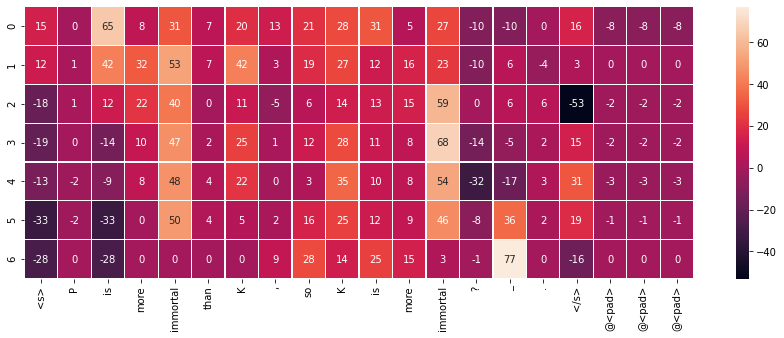

In [165]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(n_layers))
ax = sns.heatmap((np.array(layer_attrs) * 100).astype('int64'), xticklabels=xticklabels, yticklabels=yticklabels, annot=True, fmt='d', linewidth=0.2)
# plt.xlabel('Tokens')
# plt.ylabel('Layers')
plt.show()

In [167]:
remove_interpretable_embedding_layer(model, interpretable_embedding)

In [125]:
_ = model.eval()
model.zero_grad()
inputs = trainer._prepare_inputs(inputs, model)
# with torch.no_grad():
_, logits, probe_logits, all_attentions = model(**inputs, output_attentions=True, detach=False)[:4]

attn_scores, attn_probs = zip(*all_attentions)
# attn_scores, attn_probs = torch.stack(attn_scores, dim=0), torch.stack(attn_probs, dim=0)
# attn_probs = attn_probs.cpu()

In [126]:
base_layer, layer = 6, 6
H, bsz = 12, probe_logits.size(0)
tc_labels = inputs['tc_labels'][inputs['tc_labels'] != -100]
a = attn_probs[layer][:, head]
attn_probs[layer].retain_grad()
probe_logits[torch.arange(bsz), (layer - base_layer) * H: (layer - base_layer + 1) * H, tc_labels].mean().backward()
so_token_id, mask_token_id = tokenizer._convert_token_to_id('Ġso'), tokenizer.mask_token_id
pos = (inputs['input_ids'] == mask_token_id).nonzero()[:, 1].item()
tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))

0.5317388772964478

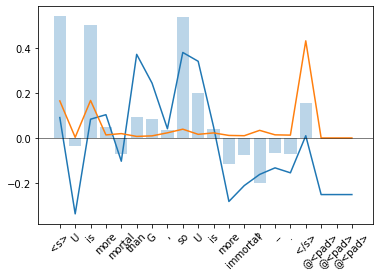

In [133]:
head = 11
ga = attn_probs[layer].grad[:, head][0, pos]
a = attn_probs[layer][:, head][0, pos]
nn.Softmax(dim=-1)(probe_logits)[torch.arange(bsz), (layer - base_layer) * H + head, tc_labels].item()

_ = plt.plot(normalize(ga.cpu()))
_ = plt.plot(a.detach().cpu())
_ = plt.bar(range(len(tokens)), normalize((ga * a.detach()).cpu()), alpha=0.3)
_ = plt.axhline(y=0, linewidth=0.5, color='k')
_ = plt.xticks(range(len(tokens)), tokens, rotation=45)

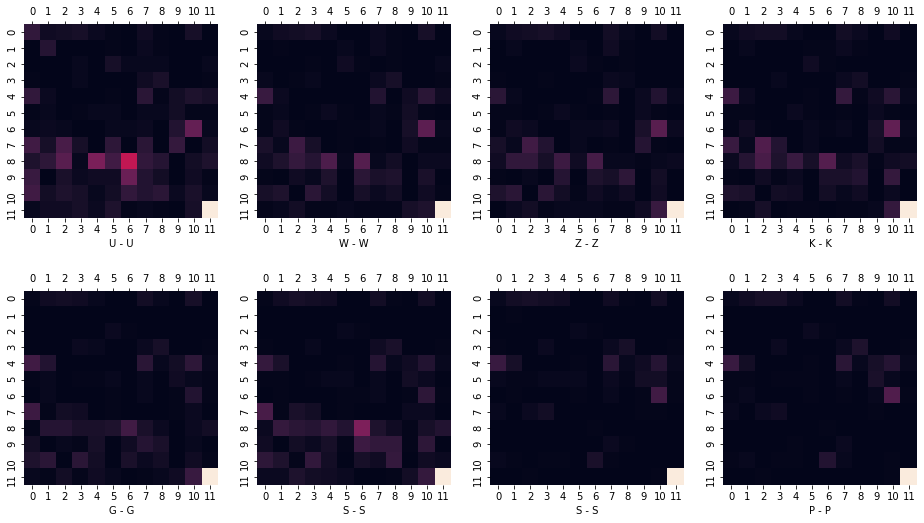

In [406]:
sample_indices = [[0, 1, 2, 3], 
                  [4, 5, 6, 7]]
# sample_indices = [[0, 0], 
#                   [0, 0]]
n_rows, n_cols = len(sample_indices), len(sample_indices[0])
fig, axs = plt.subplots(n_rows, n_cols, sharey=False, figsize=(4 * n_cols, 4.5 * n_rows))
sep_id = tokenizer._convert_token_to_id('Ġ,')
for row in range(n_rows):
    for col in range(n_cols):
        i, ax = sample_indices[row][col], axs[row][col]
        tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(inputs['input_ids'][i]))
        
        p, h = inputs['marked_pos_labels'][i][0]
        p, h = p.item(), h.item()
        so_pos = (inputs['input_ids'][i] == tokenizer._convert_token_to_id('Ġso')).nonzero()[0, 0].item()
        be2_pos = so_pos + 2
        mask_pos = (inputs['input_ids'][i] == tokenizer.mask_token_id).nonzero()[0, 0].item()
#         j = 17
        pos_attn = attn_probs[:, i, :, mask_pos, h]
        pos_attn[-1, -1] = 1.
        ax = sns.heatmap((pos_attn * 100).long(), square=True, cbar=False, annot=False, fmt='d', ax=ax)
        ax.tick_params(top=True, labeltop=True)
        _ = ax.set_xlabel('%s - %s' % (tokens[p], tokens[h]))

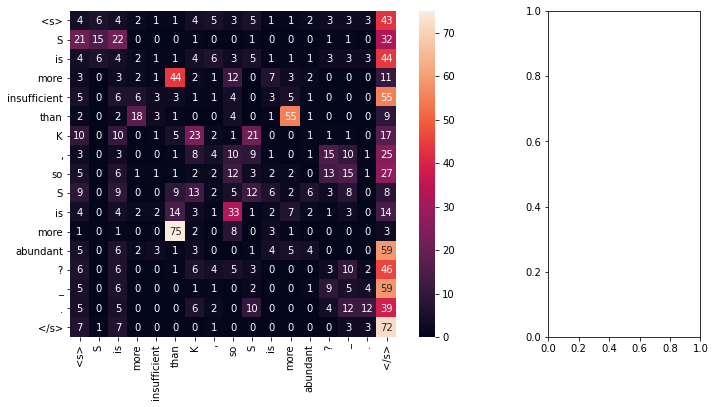

In [423]:
i = 6
layer, head = 4, 8
seq_len = inputs['attention_mask'][i].sum().item()
attn =  attn_probs[layer, i, head, : seq_len, : seq_len]
tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(inputs['input_ids'][i])[: seq_len])
size = round(attn.size(0) / 3)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(size  * 2., size), gridspec_kw={'width_ratios': [3, 1]})
_ = sns.heatmap((attn * 100).long(), square=True, cbar=True, annot=True, fmt='d', xticklabels=tokens, yticklabels=tokens, ax=ax0)
# plot_head_attn(attn, tokens, ax1=ax1, marked_positions=inputs['marked_pos_labels'][i])

H6-4: ,/so/is/more -> h_ent
H6-6: ,/so/is/more -> h
H6-10: ,/so/is/more -> p
H7-9: ?/mask -> so

In [ ]:
#         pos_attn = attn_probs[:, i]
#         pos_attn = pos_attn * (pos_attn > 0.3)
# #         pos_attn[0] = 0  # layer 0
# #         pos_attn[1, 1] = 0  # ->pos-2
#         pos_attn = pos_attn.mean(dim=(0, 1))
#         input_ids = inputs['input_ids'][i]
#         sep_pos = (input_ids == sep_id).nonzero()[0].item()
#         segment_ids = torch.zeros_like(input_ids)
#         segment_ids[sep_pos + 1:] = 1
#         segment_mask = segment_ids.unsqueeze(0) != segment_ids.unsqueeze(1)
#         pos_attn = pos_attn * segment_mask.cpu()
#         seq_len = inputs['attention_mask'][i].sum().item()
#         pos_attn[:, [0, 2, seq_len - 1]] = 0
#         k = torch.arange(1, pos_attn.size(0) - 1)
#         pos_attn[k, k] = 0
#         pos_attn[k, k - 1] = 0
#         pos_attn[k, k + 1] = 0
#         ax = sns.heatmap((pos_attn * 100).long(), square=True, cbar=False, annot=False, fmt='d', 
#                          xticklabels=tokens, yticklabels=tokens, ax=ax)